# DINO Clustering

In [1]:
import gc
import os
import sys
from copy import deepcopy
from time import sleep, time

import kornia as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycolmap
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
from IPython.display import clear_output
from scripts import utils, database, features

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = K.utils.get_cuda_device_if_available(0)
print(f"{device=}")

device=device(type='cuda', index=0)


In [3]:
DATA_DIR = "../data/image-matching-challenge-2025"
DINO_DIR = "weights/dinov2"
OUTPUT_FILE = "train_predictions.csv"

DB_IMG_EXT = ""
DB_CAMERA_MODEL = "simple-pinhole"

# Configure dataset filtering 
DATASETS_FILTER = [
    # New 2025 datasets
    "amy_gardens",
    "ETs",
    "fbk_vineyard",
    "stairs",
    # Data from IMC 2023 and 2024.
    'imc2024_dioscuri_baalshamin',
    'imc2023_theather_imc2024_church',
    'imc2023_heritage',
    'imc2023_haiper',
    'imc2024_lizard_pond',
    # Crowdsourced PhotoTourism data.
    'pt_stpeters_stpauls',
    'pt_brandenburg_british_buckingham',
    'pt_piazzasanmarco_grandplace',
    'pt_sacrecoeur_trevi_tajmahal',
]

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

In [5]:
# Load the dataset
samples = utils.dataset.load_dataset(DATA_DIR)

for dataset in samples:
    print(f'Dataset "{dataset}" -> num_images={len(samples[dataset])}')

Dataset "imc2023_haiper" -> num_images=54
Dataset "imc2023_heritage" -> num_images=209
Dataset "imc2023_theather_imc2024_church" -> num_images=76
Dataset "imc2024_dioscuri_baalshamin" -> num_images=138
Dataset "imc2024_lizard_pond" -> num_images=214
Dataset "pt_brandenburg_british_buckingham" -> num_images=225
Dataset "pt_piazzasanmarco_grandplace" -> num_images=168
Dataset "pt_sacrecoeur_trevi_tajmahal" -> num_images=225
Dataset "pt_stpeters_stpauls" -> num_images=200
Dataset "amy_gardens" -> num_images=200
Dataset "fbk_vineyard" -> num_images=163
Dataset "ETs" -> num_images=22
Dataset "stairs" -> num_images=51


## Clustering Analysis

In [6]:
datasets = {}
for dataset in df['dataset'].unique():
    datasets[dataset] = {}
    dataset_rows = df[df['dataset'] == dataset]
    for scene in dataset_rows['scene'].unique():
        datasets[dataset][scene] = []
        scene_rows = dataset_rows[dataset_rows['scene'] == scene]
        image_paths = [os.path.join(DATA_DIR, 'train', dataset, path) for path in scene_rows['image']]
        print(f"Generating descriptors for {dataset}/{scene} -> num_images={len(image_paths)}")
        global_descriptors = features.extraction.extract_cls_descriptor_dino(
            image_paths,
            dino_path=DINO_DIR,
            device=device,
            normalize=True
        )
        datasets[dataset][scene] = global_descriptors

Generating descriptors for imc2023_haiper/fountain -> num_images=23


100%|██████████| 23/23 [00:04<00:00,  5.25it/s]


Generating descriptors for imc2023_haiper/bike -> num_images=15


100%|██████████| 15/15 [00:02<00:00,  5.82it/s]


Generating descriptors for imc2023_haiper/chairs -> num_images=16


100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


Generating descriptors for imc2023_heritage/outliers -> num_images=61


100%|██████████| 61/61 [00:06<00:00,  8.82it/s]


Generating descriptors for imc2023_heritage/dioscuri -> num_images=75


100%|██████████| 75/75 [00:03<00:00, 24.27it/s]


Generating descriptors for imc2023_heritage/cyprus -> num_images=30


100%|██████████| 30/30 [00:45<00:00,  1.53s/it]


Generating descriptors for imc2023_heritage/wall -> num_images=43


100%|██████████| 43/43 [01:02<00:00,  1.46s/it]


Generating descriptors for imc2023_theather_imc2024_church/church -> num_images=50


100%|██████████| 50/50 [00:02<00:00, 22.57it/s]


Generating descriptors for imc2023_theather_imc2024_church/kyiv-puppet-theater -> num_images=26


100%|██████████| 26/26 [00:02<00:00, 12.16it/s]


Generating descriptors for imc2024_dioscuri_baalshamin/baalshamin -> num_images=49


100%|██████████| 49/49 [00:09<00:00,  5.12it/s]


Generating descriptors for imc2024_dioscuri_baalshamin/outliers -> num_images=24


100%|██████████| 24/24 [00:00<00:00, 25.87it/s]


Generating descriptors for imc2024_dioscuri_baalshamin/dioscuri -> num_images=65


100%|██████████| 65/65 [00:02<00:00, 24.93it/s]


Generating descriptors for imc2024_lizard_pond/lizard -> num_images=90


100%|██████████| 90/90 [00:03<00:00, 26.98it/s]


Generating descriptors for imc2024_lizard_pond/outliers -> num_images=34


100%|██████████| 34/34 [00:01<00:00, 20.85it/s]


Generating descriptors for imc2024_lizard_pond/pond -> num_images=90


100%|██████████| 90/90 [00:03<00:00, 27.17it/s]


Generating descriptors for pt_brandenburg_british_buckingham/british_museum -> num_images=75


100%|██████████| 75/75 [00:02<00:00, 26.23it/s]


Generating descriptors for pt_brandenburg_british_buckingham/buckingham_palace -> num_images=75


100%|██████████| 75/75 [00:02<00:00, 25.81it/s]


Generating descriptors for pt_brandenburg_british_buckingham/brandenburg_gate -> num_images=75


100%|██████████| 75/75 [00:03<00:00, 24.84it/s]


Generating descriptors for pt_piazzasanmarco_grandplace/piazza_san_marco -> num_images=68


100%|██████████| 68/68 [00:02<00:00, 23.96it/s]


Generating descriptors for pt_piazzasanmarco_grandplace/grand_place_brussels -> num_images=100


100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Generating descriptors for pt_sacrecoeur_trevi_tajmahal/trevi_fountain -> num_images=75


100%|██████████| 75/75 [00:03<00:00, 24.03it/s]


Generating descriptors for pt_sacrecoeur_trevi_tajmahal/sacre_coeur -> num_images=75


100%|██████████| 75/75 [00:03<00:00, 24.95it/s]


Generating descriptors for pt_sacrecoeur_trevi_tajmahal/taj_mahal -> num_images=75


100%|██████████| 75/75 [00:02<00:00, 25.76it/s]


Generating descriptors for pt_stpeters_stpauls/st_pauls_cathedral -> num_images=100


100%|██████████| 100/100 [00:03<00:00, 25.61it/s]


Generating descriptors for pt_stpeters_stpauls/st_peters_square -> num_images=100


100%|██████████| 100/100 [00:03<00:00, 25.89it/s]


Generating descriptors for amy_gardens/peach -> num_images=200


100%|██████████| 200/200 [00:07<00:00, 26.63it/s]


Generating descriptors for fbk_vineyard/vineyard_split_2 -> num_images=35


100%|██████████| 35/35 [00:00<00:00, 52.17it/s]


Generating descriptors for fbk_vineyard/vineyard_split_3 -> num_images=85


100%|██████████| 85/85 [00:01<00:00, 53.11it/s]


Generating descriptors for fbk_vineyard/vineyard_split_1 -> num_images=43


100%|██████████| 43/43 [00:00<00:00, 55.40it/s]


Generating descriptors for ETs/outliers -> num_images=3


100%|██████████| 3/3 [00:00<00:00, 68.94it/s]


Generating descriptors for ETs/ET -> num_images=9


100%|██████████| 9/9 [00:00<00:00, 41.61it/s]


Generating descriptors for ETs/another_ET -> num_images=10


100%|██████████| 10/10 [00:00<00:00, 55.21it/s]


Generating descriptors for stairs/stairs_split_1 -> num_images=28


100%|██████████| 28/28 [00:02<00:00, 13.69it/s]


Generating descriptors for stairs/stairs_split_2 -> num_images=23


100%|██████████| 23/23 [00:01<00:00, 13.38it/s]


In [7]:
all_vectors = {dataset_name: [] for dataset_name in datasets.keys()}
all_labels = {dataset_name: [] for dataset_name in datasets.keys()}
all_label_names = {dataset_name: [] for dataset_name in datasets.keys()}

for dataset_name, scenes in datasets.items():
    for cluster_id, (name, vectors) in enumerate(scenes.items()):
        all_vectors[dataset_name].extend([v.cpu().numpy() for v in vectors])
        all_labels[dataset_name].extend([cluster_id] * len(vectors))
        all_label_names[dataset_name].extend([name] * len(vectors))

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2023_haiper, Silhouette Score: 0.8199


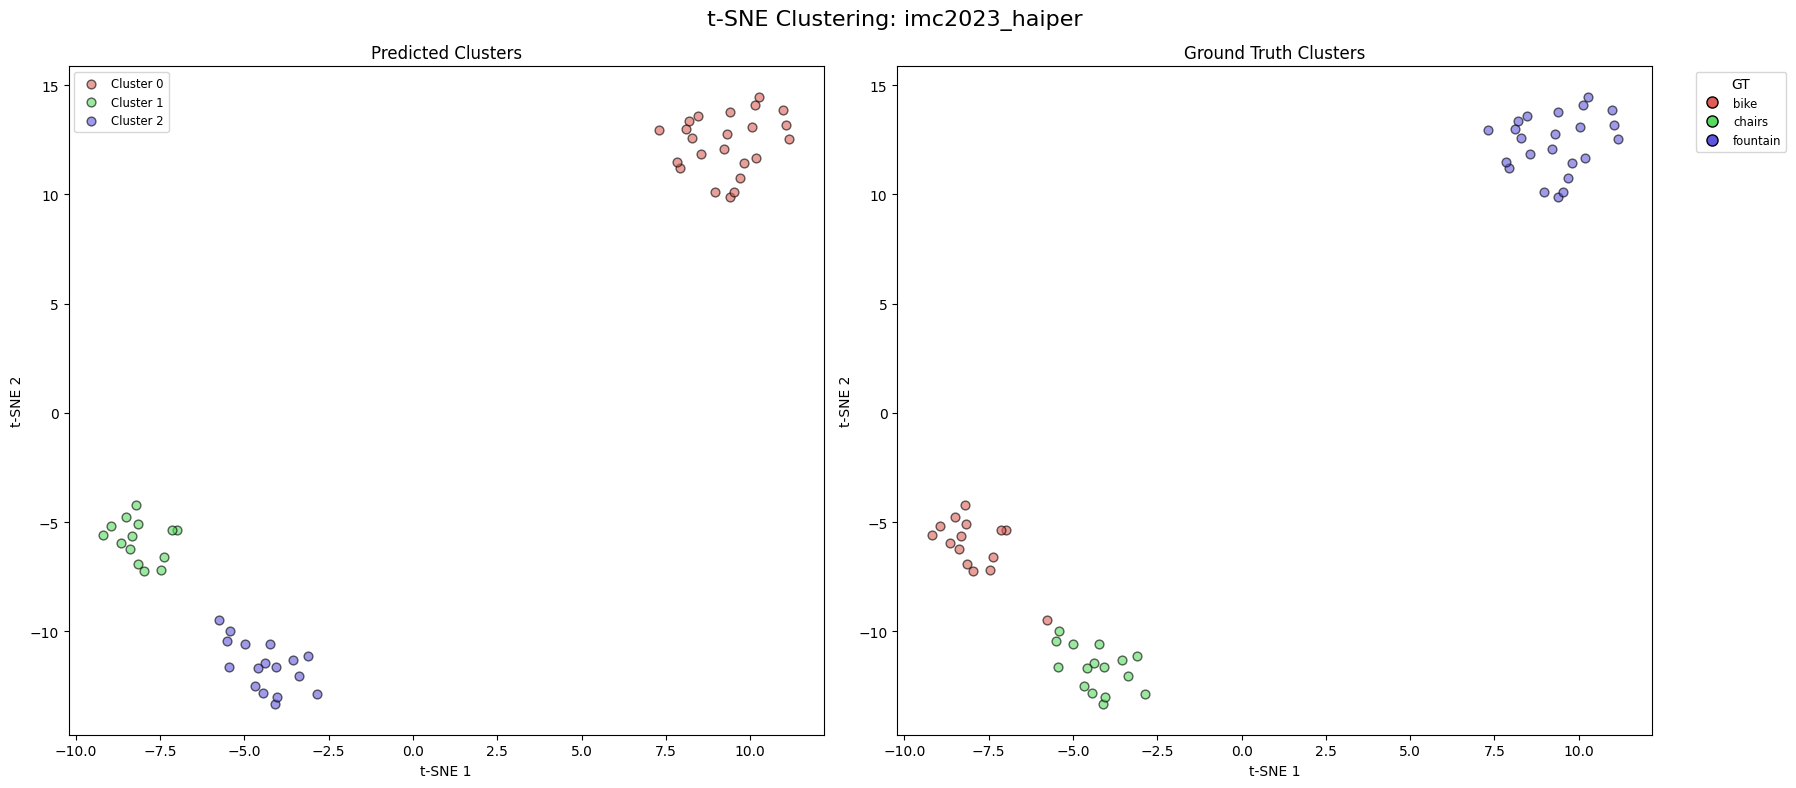

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2023_heritage, Silhouette Score: 0.4794


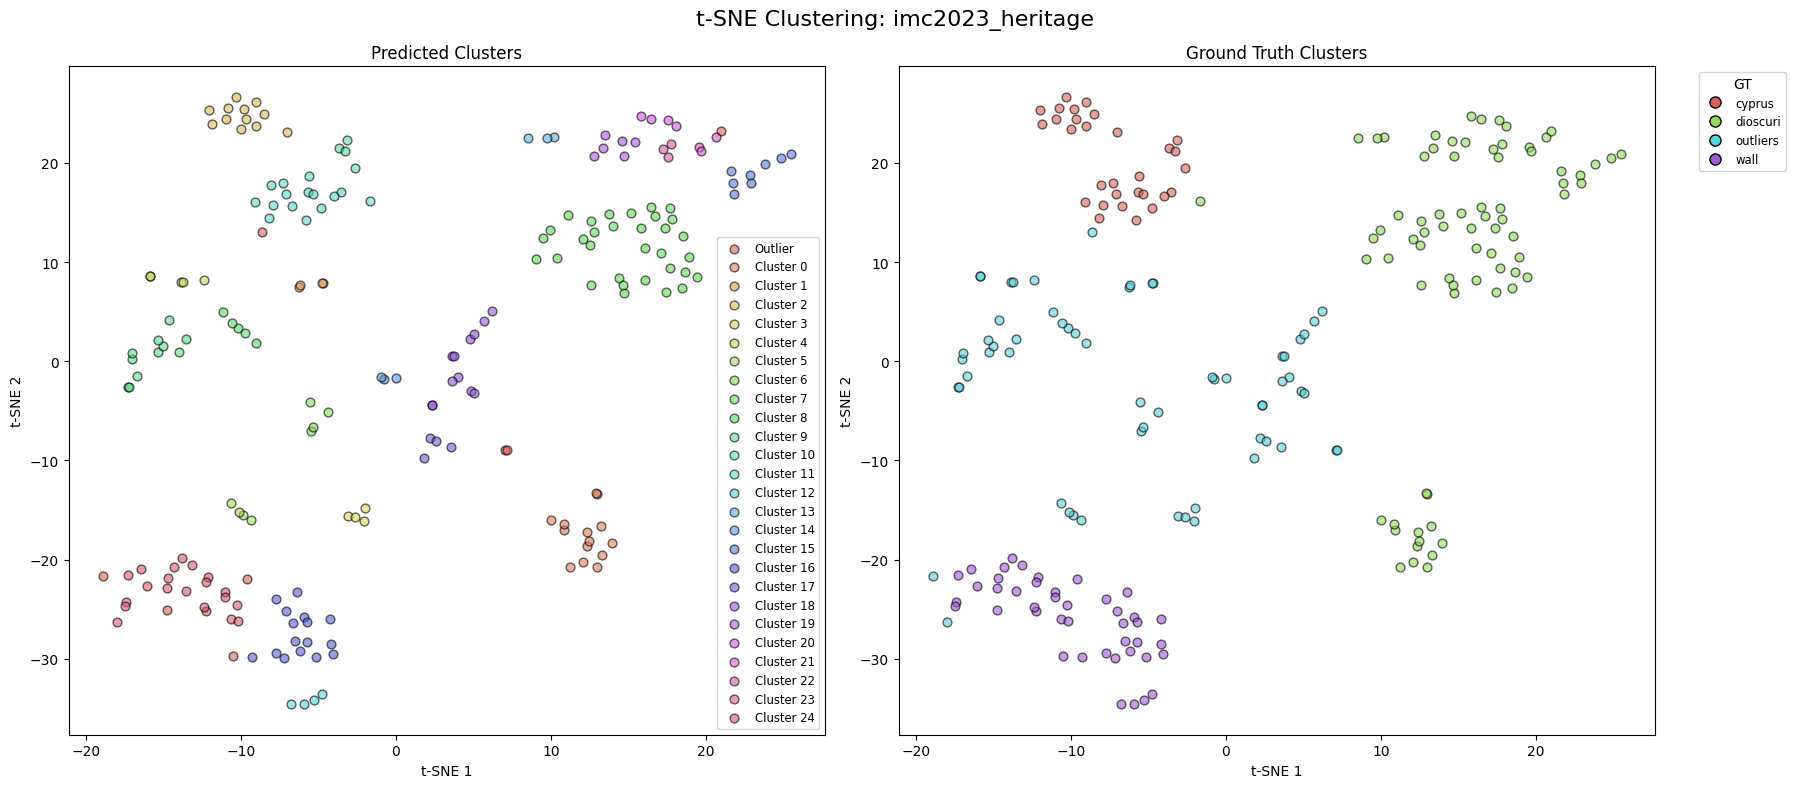

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2023_theather_imc2024_church, Silhouette Score: 0.4271


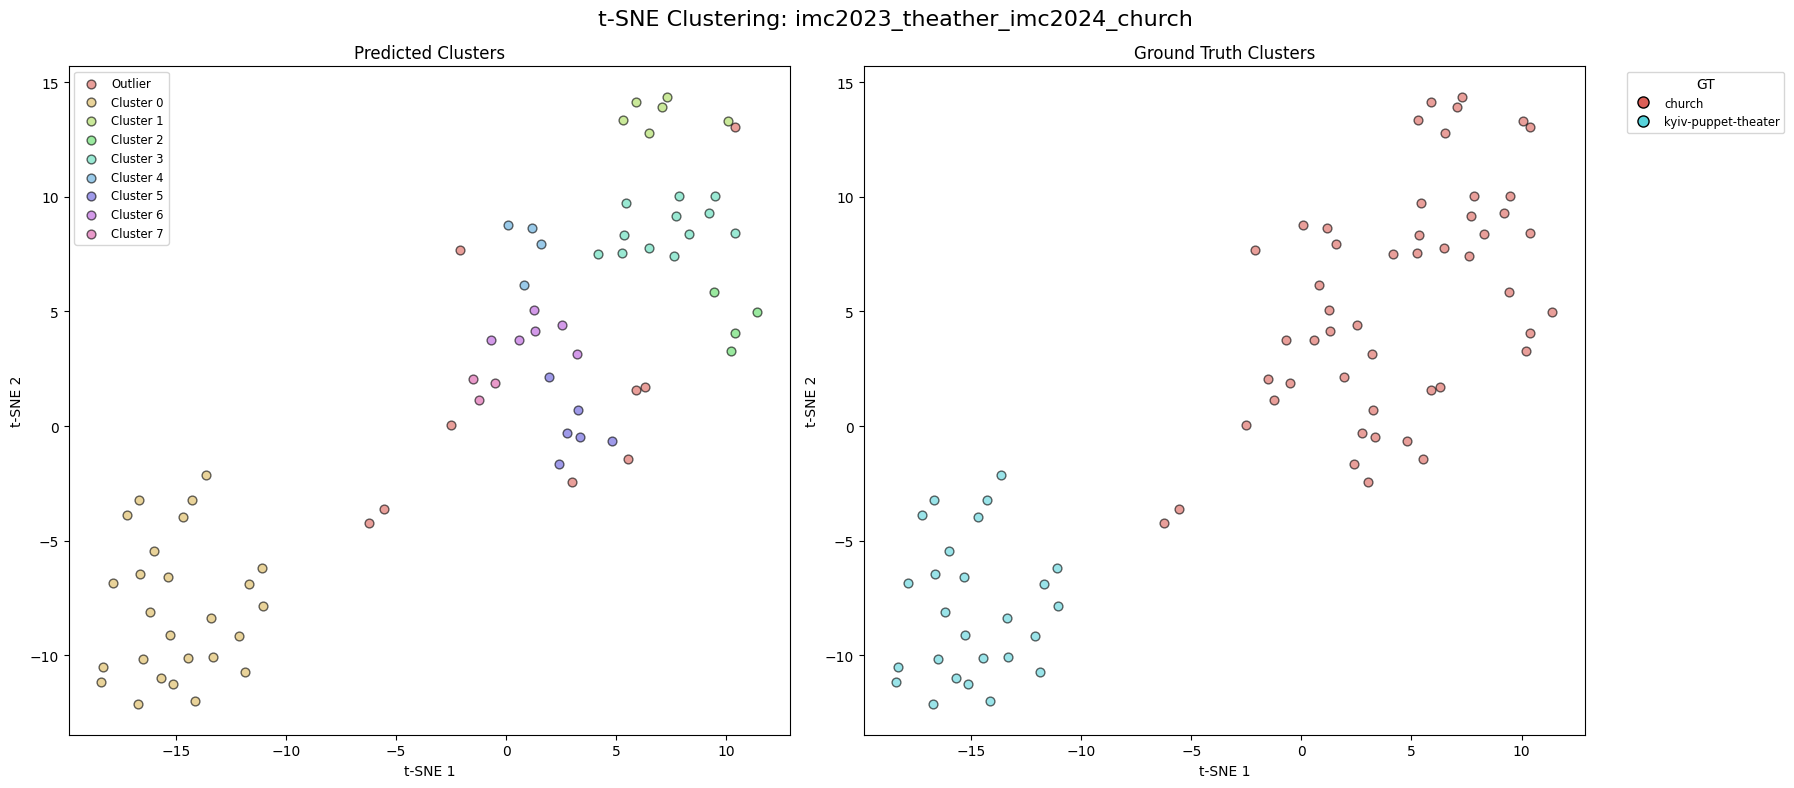

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_dioscuri_baalshamin, Silhouette Score: 0.5553


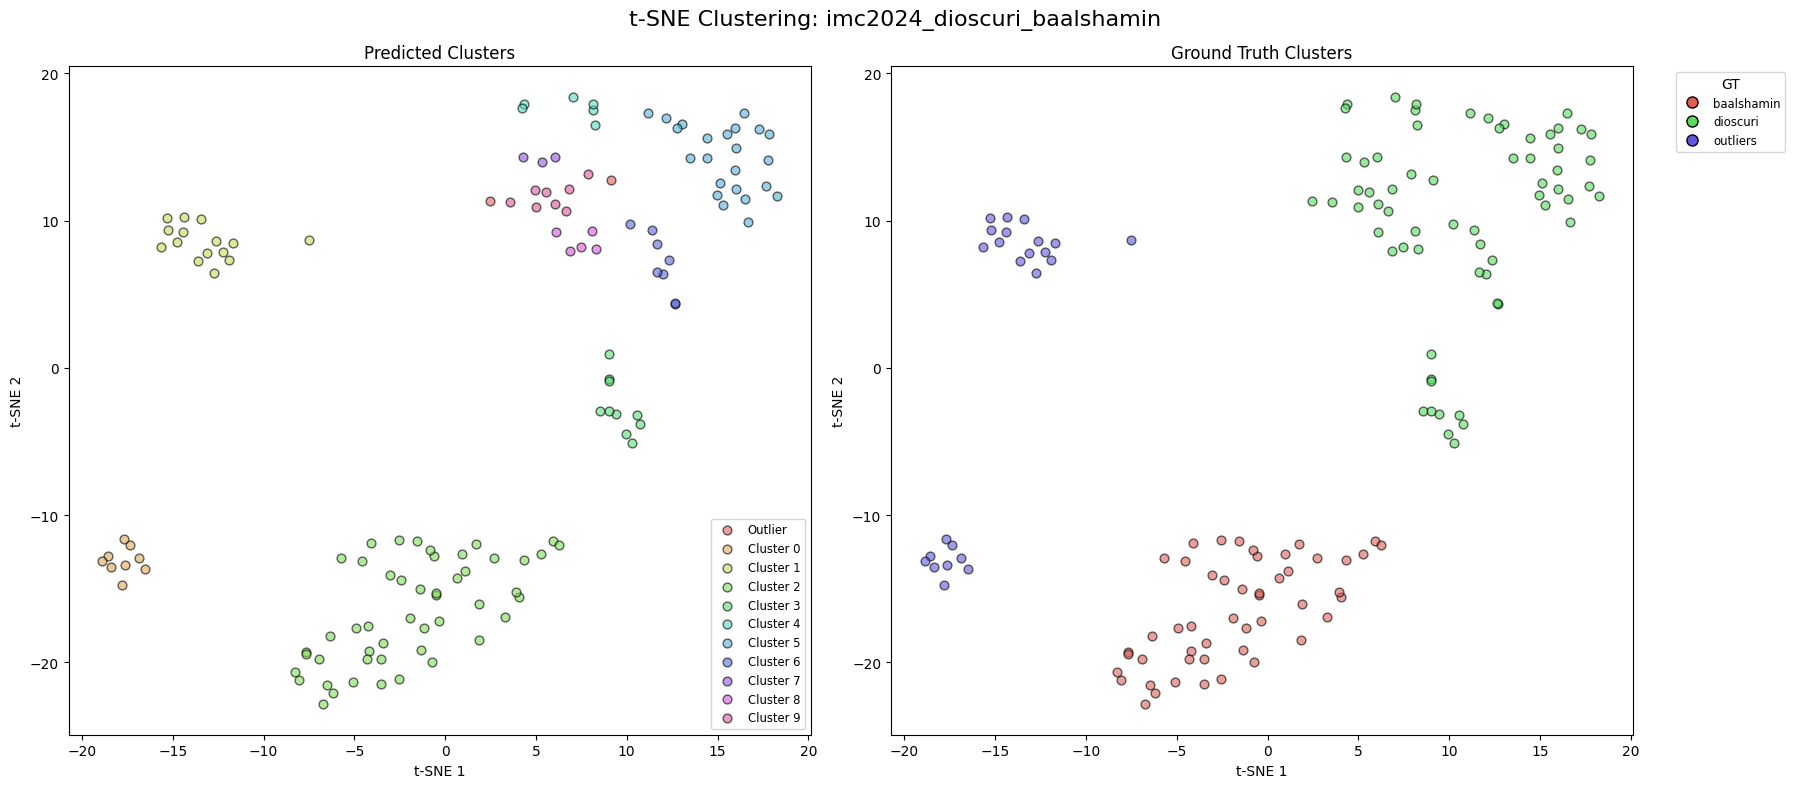

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_lizard_pond, Silhouette Score: 0.4589


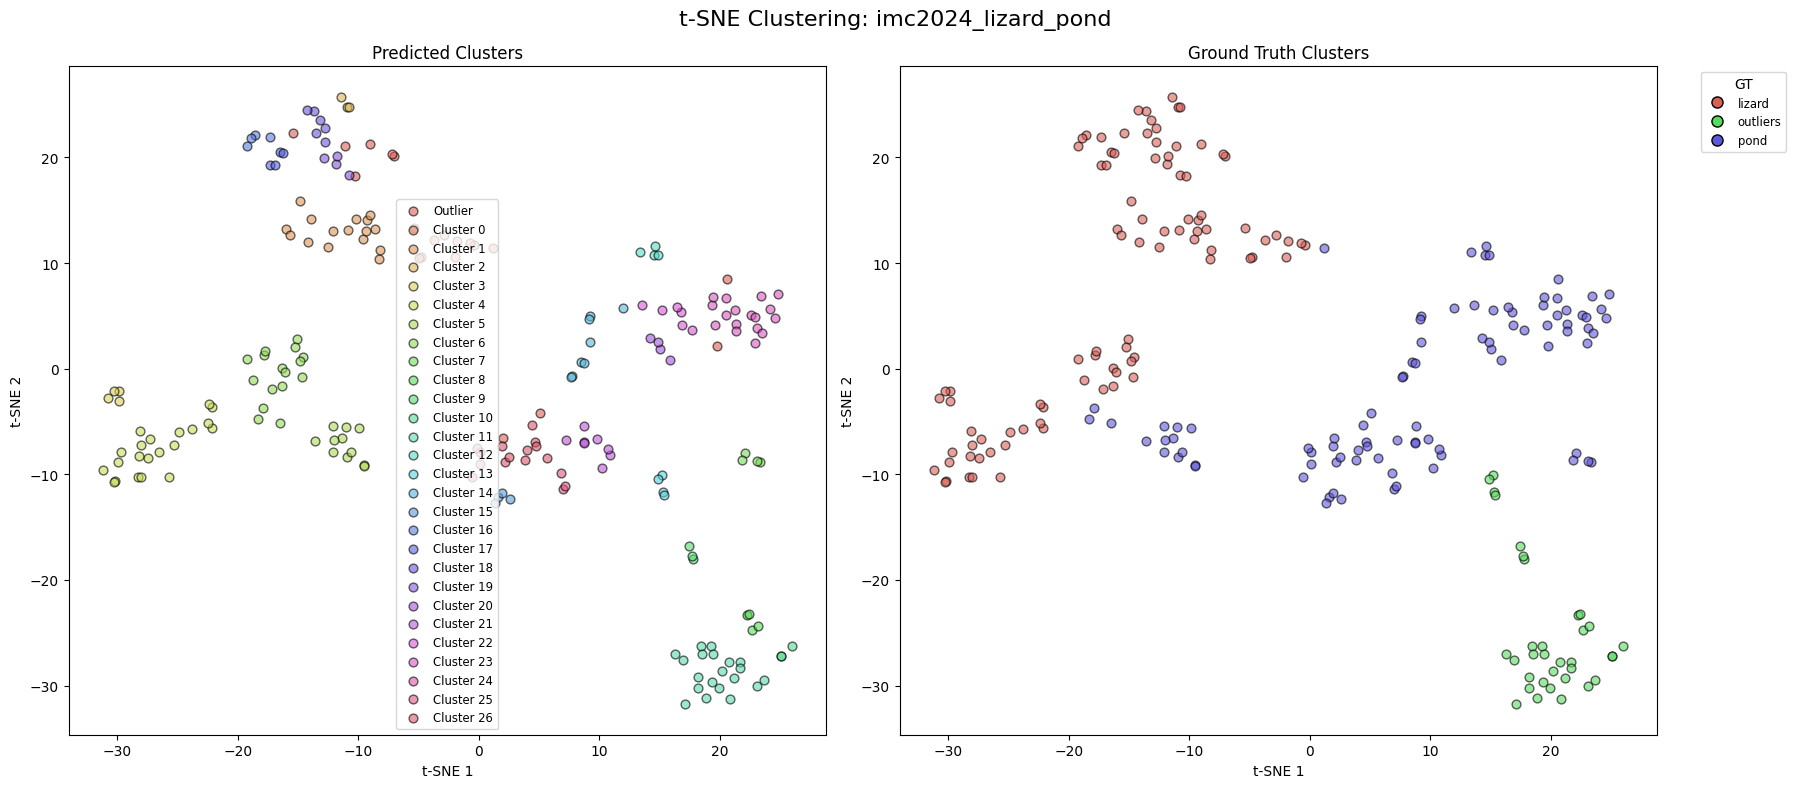

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_brandenburg_british_buckingham, Silhouette Score: 0.5494


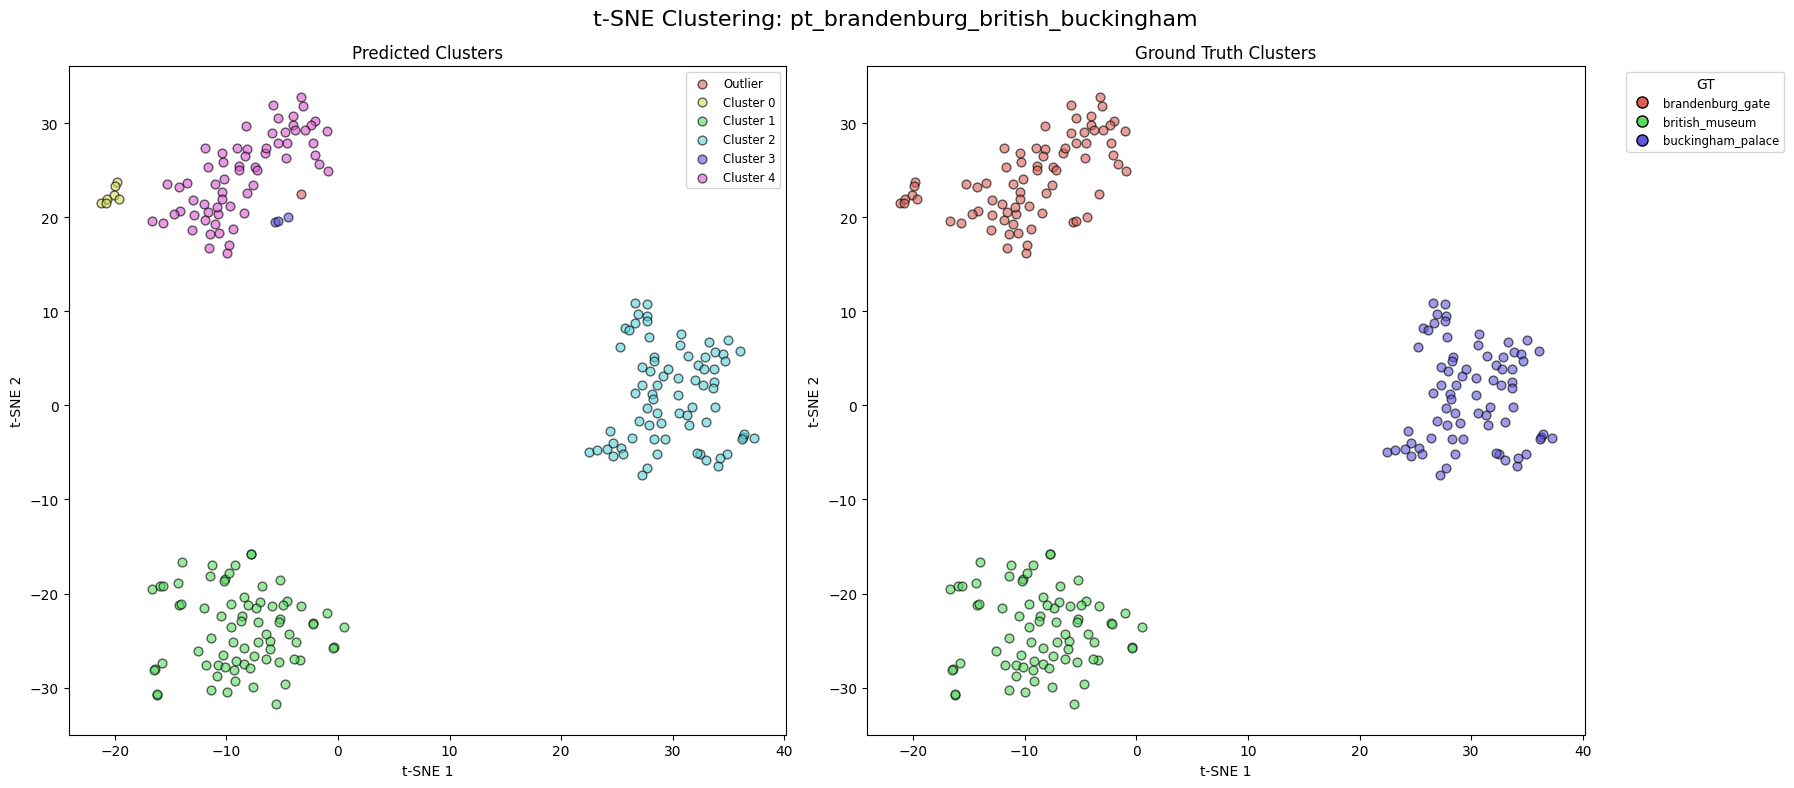

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_piazzasanmarco_grandplace, Silhouette Score: 0.5661


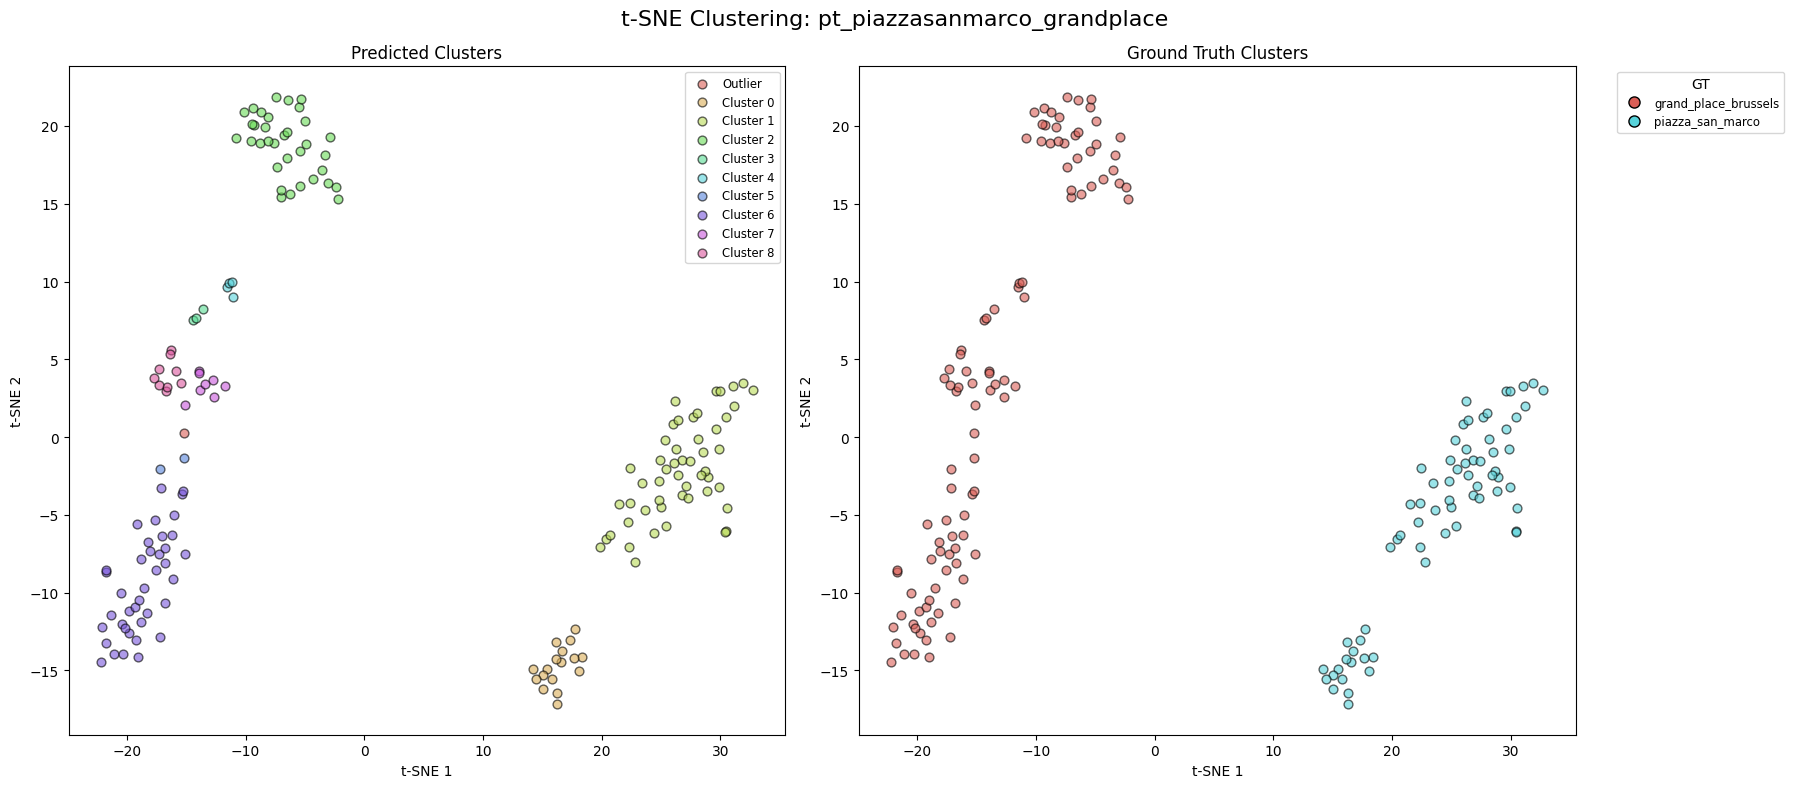

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_sacrecoeur_trevi_tajmahal, Silhouette Score: 0.5461


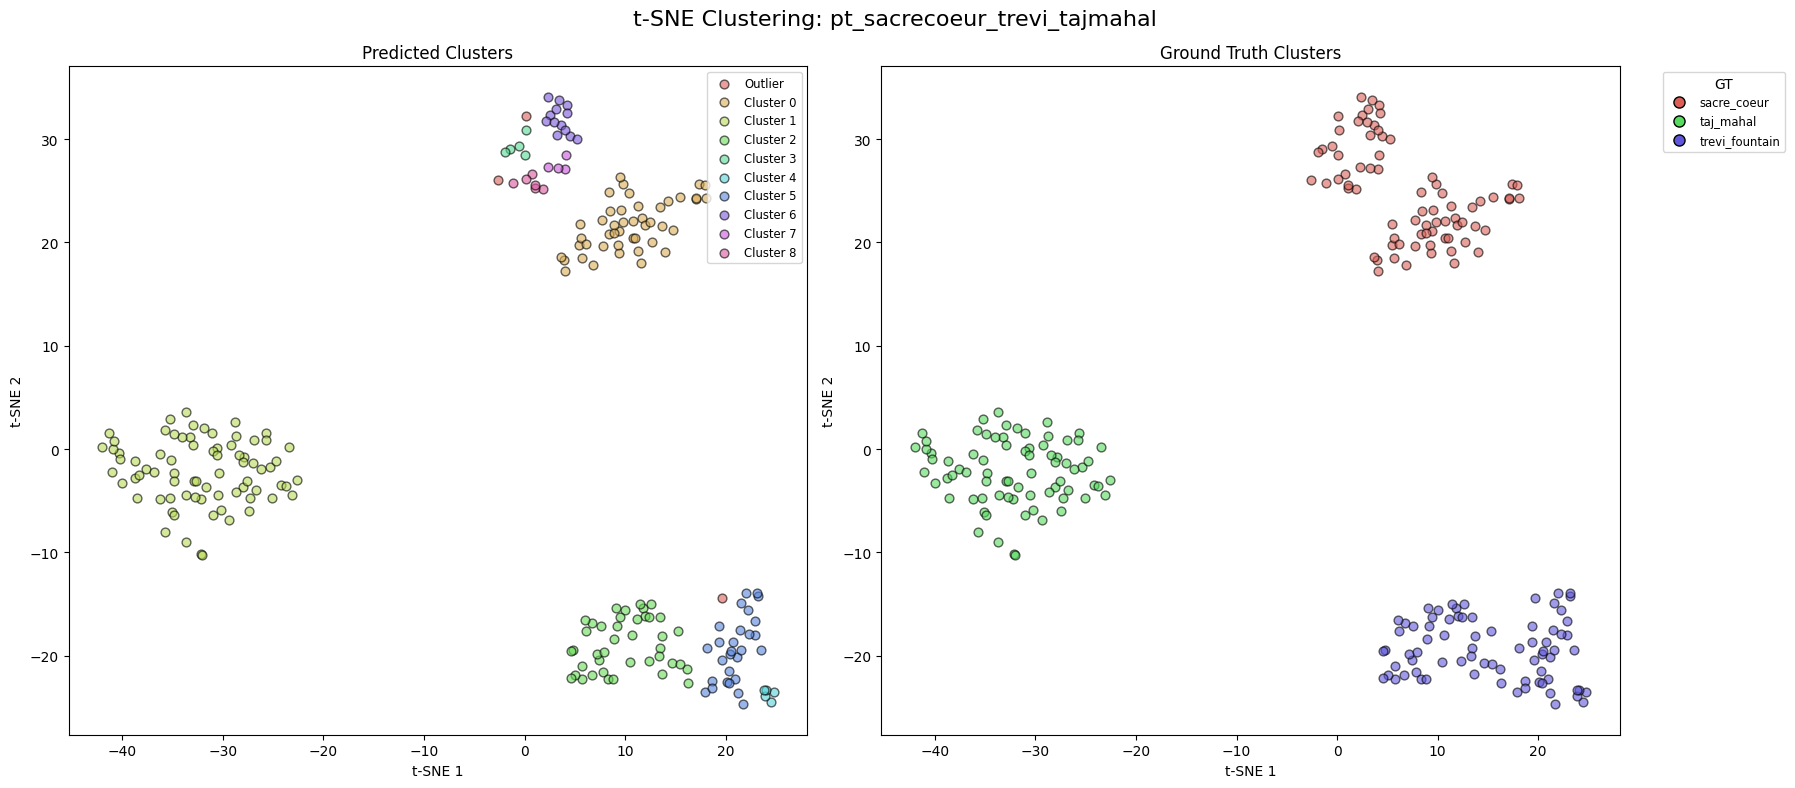

Dataset: pt_stpeters_stpauls, Silhouette Score: 0.6874


/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


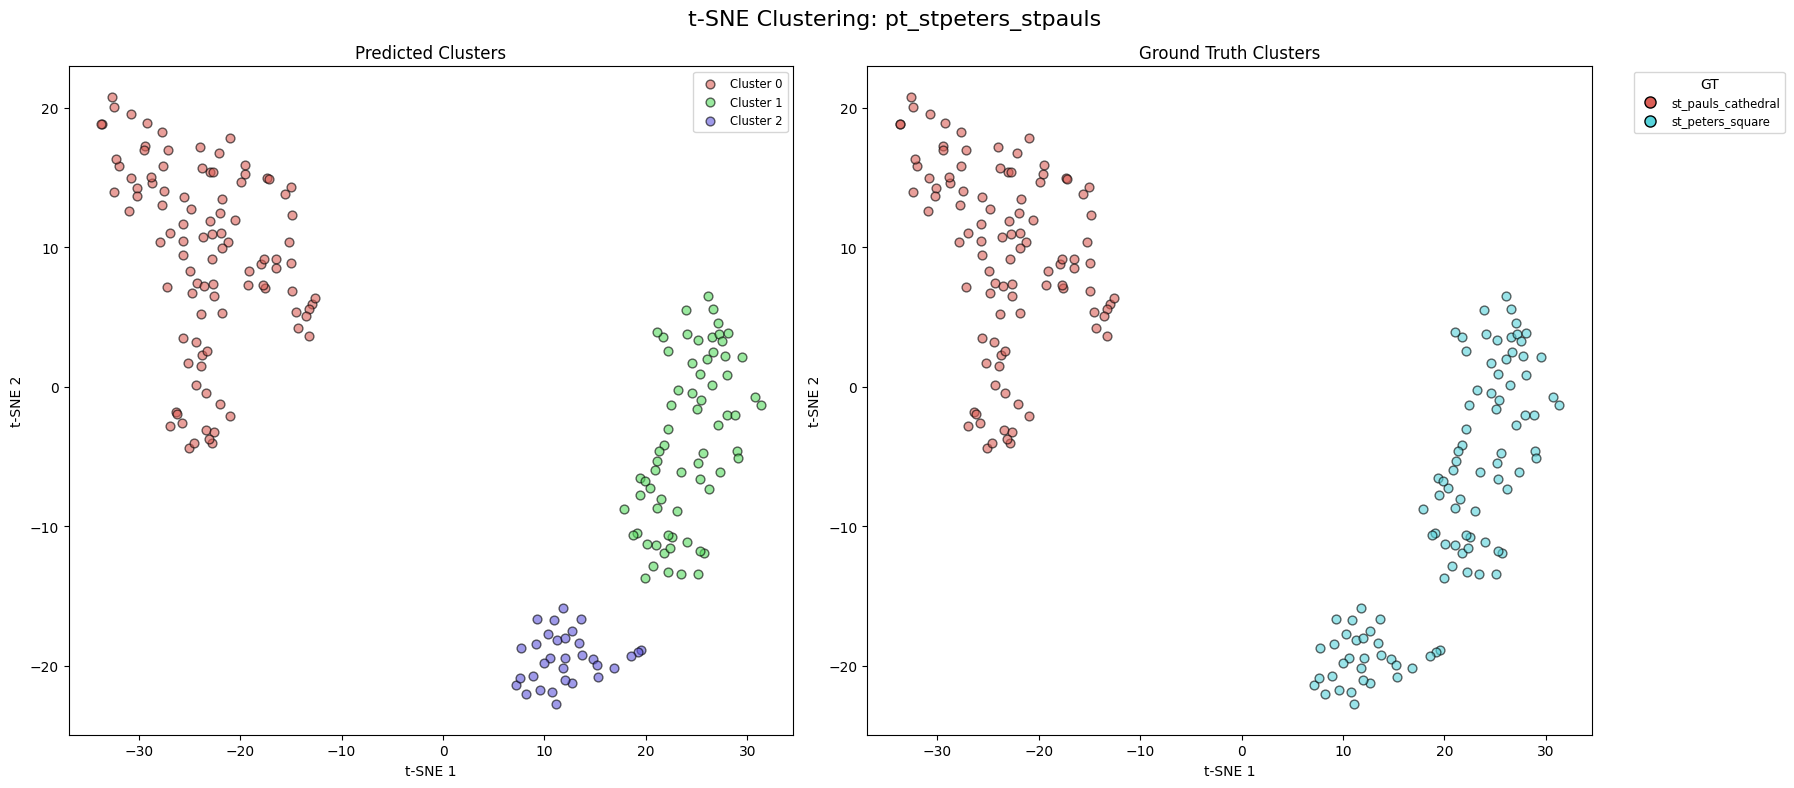

Dataset: amy_gardens, Silhouette Score: 0.5372


/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


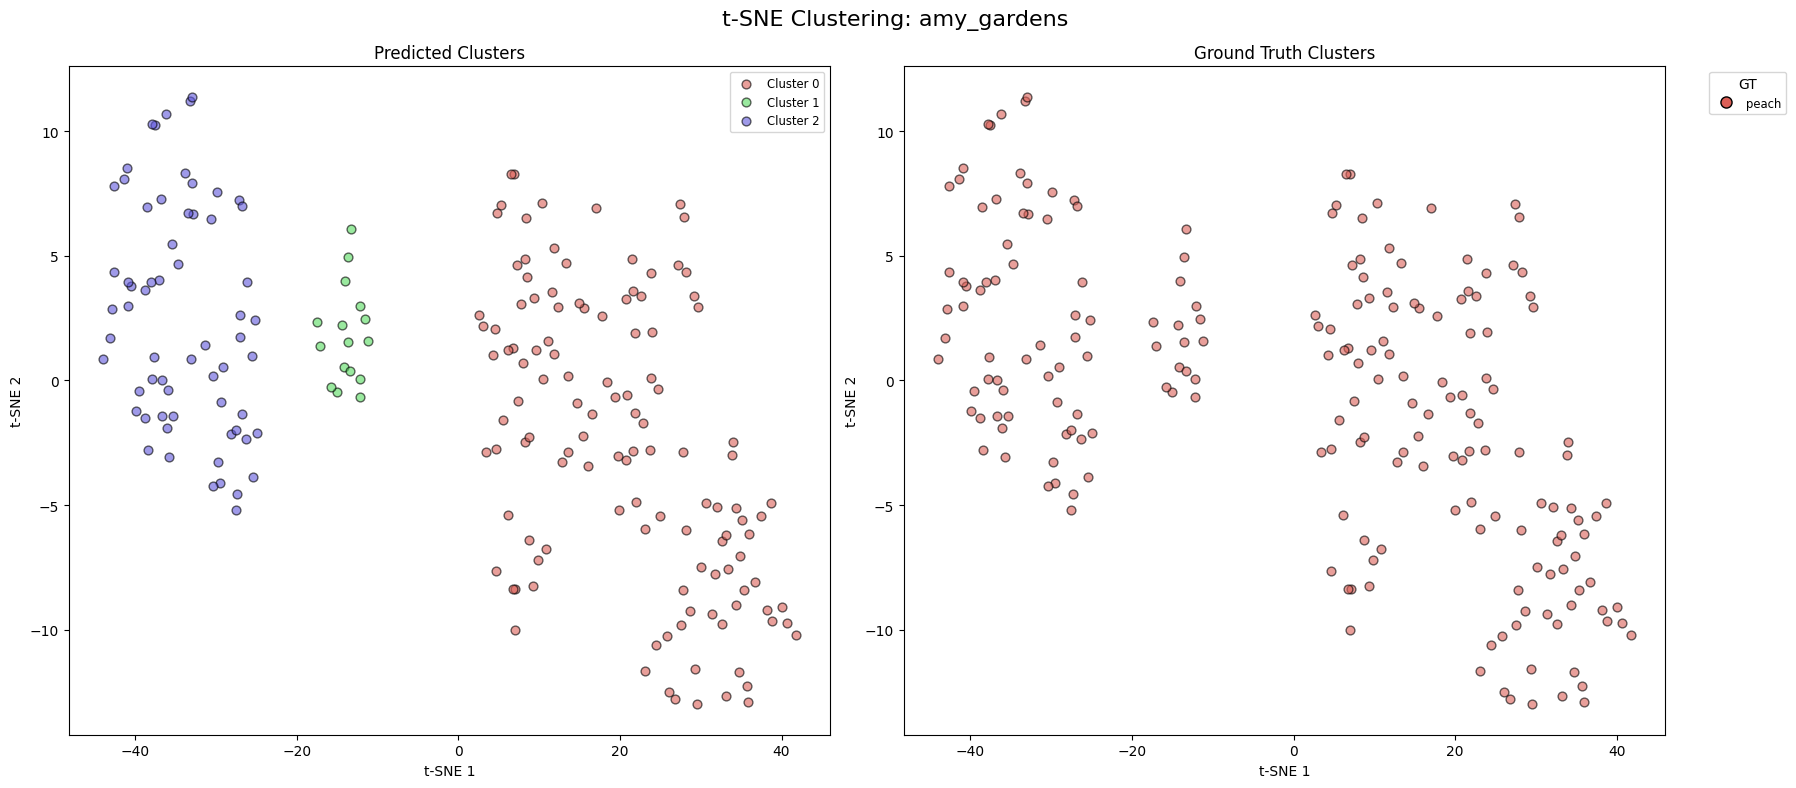

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: fbk_vineyard, Silhouette Score: 0.2441


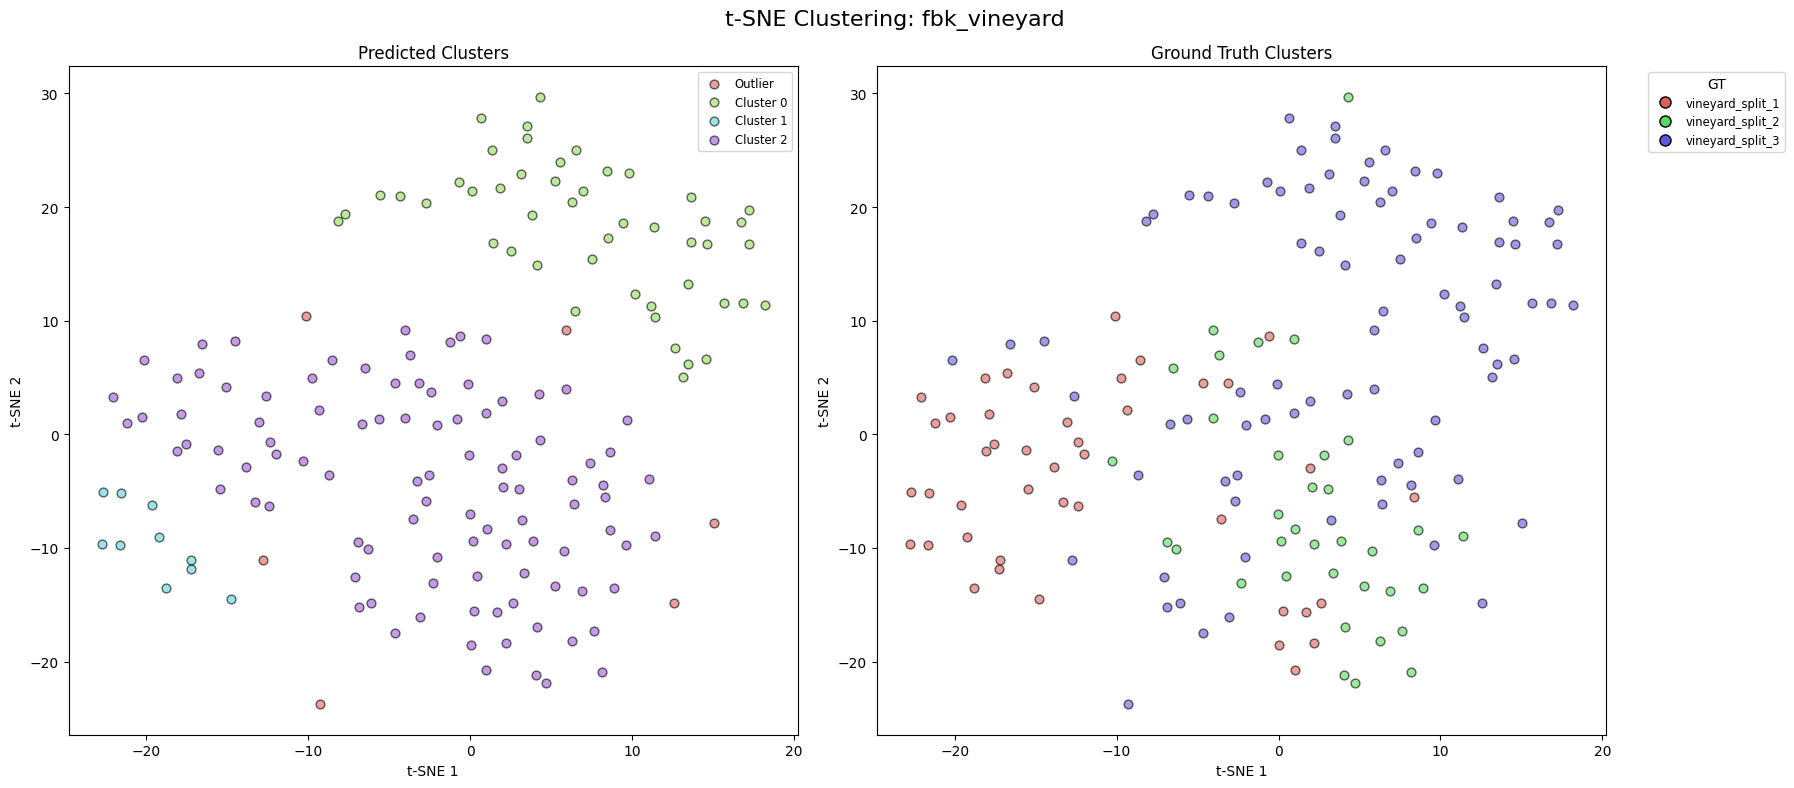

Dataset: ETs, Silhouette Score: 0.4146


/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


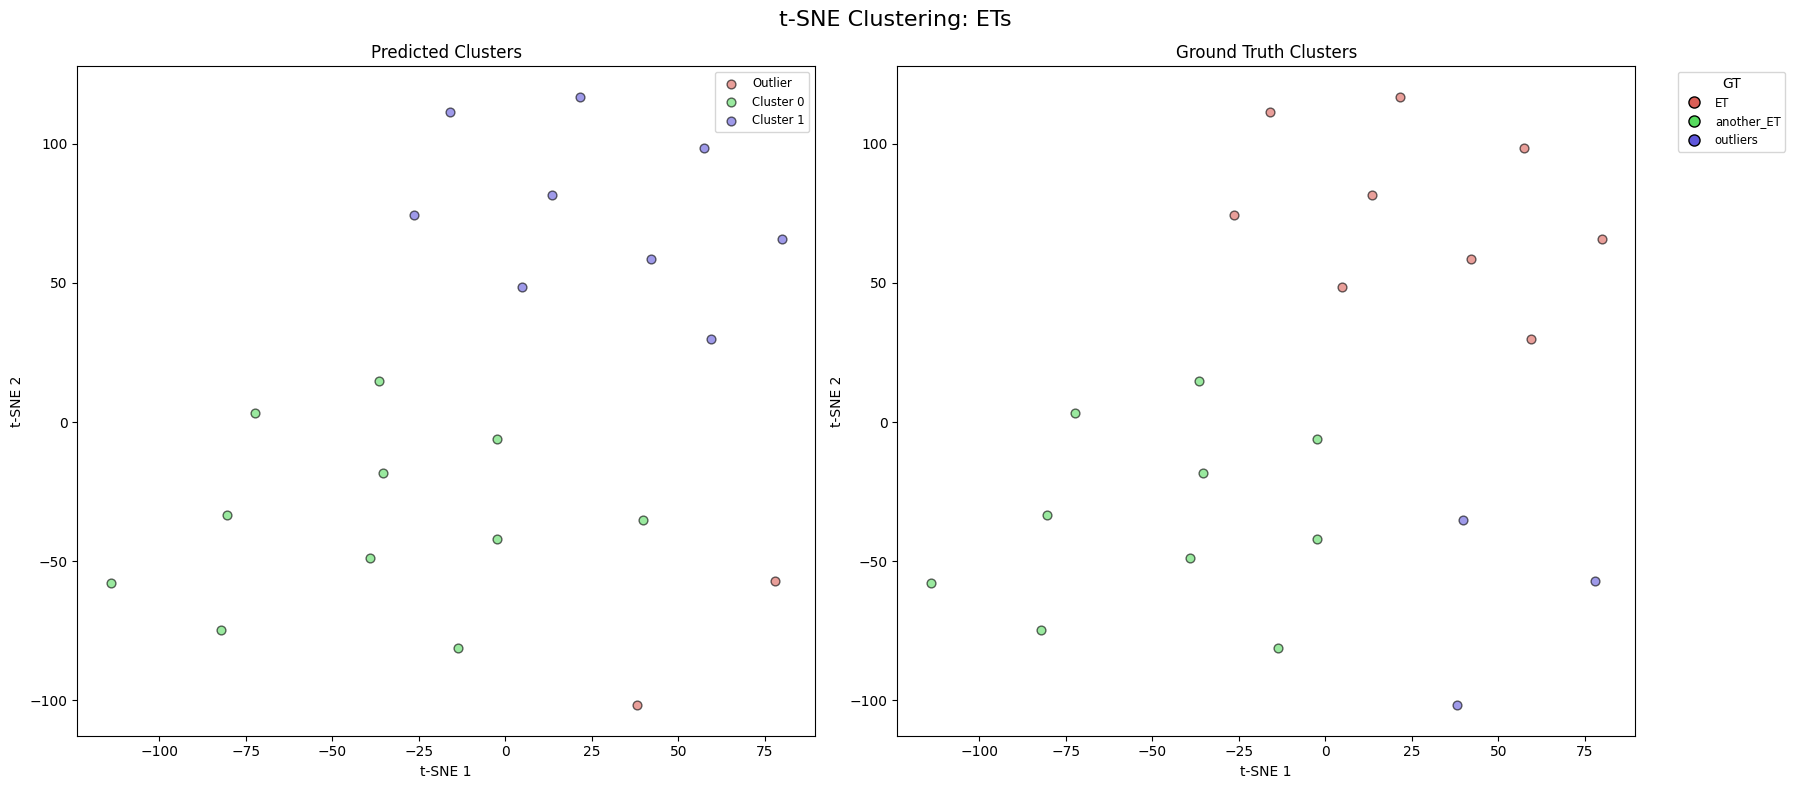

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: stairs, Silhouette Score: 0.2140


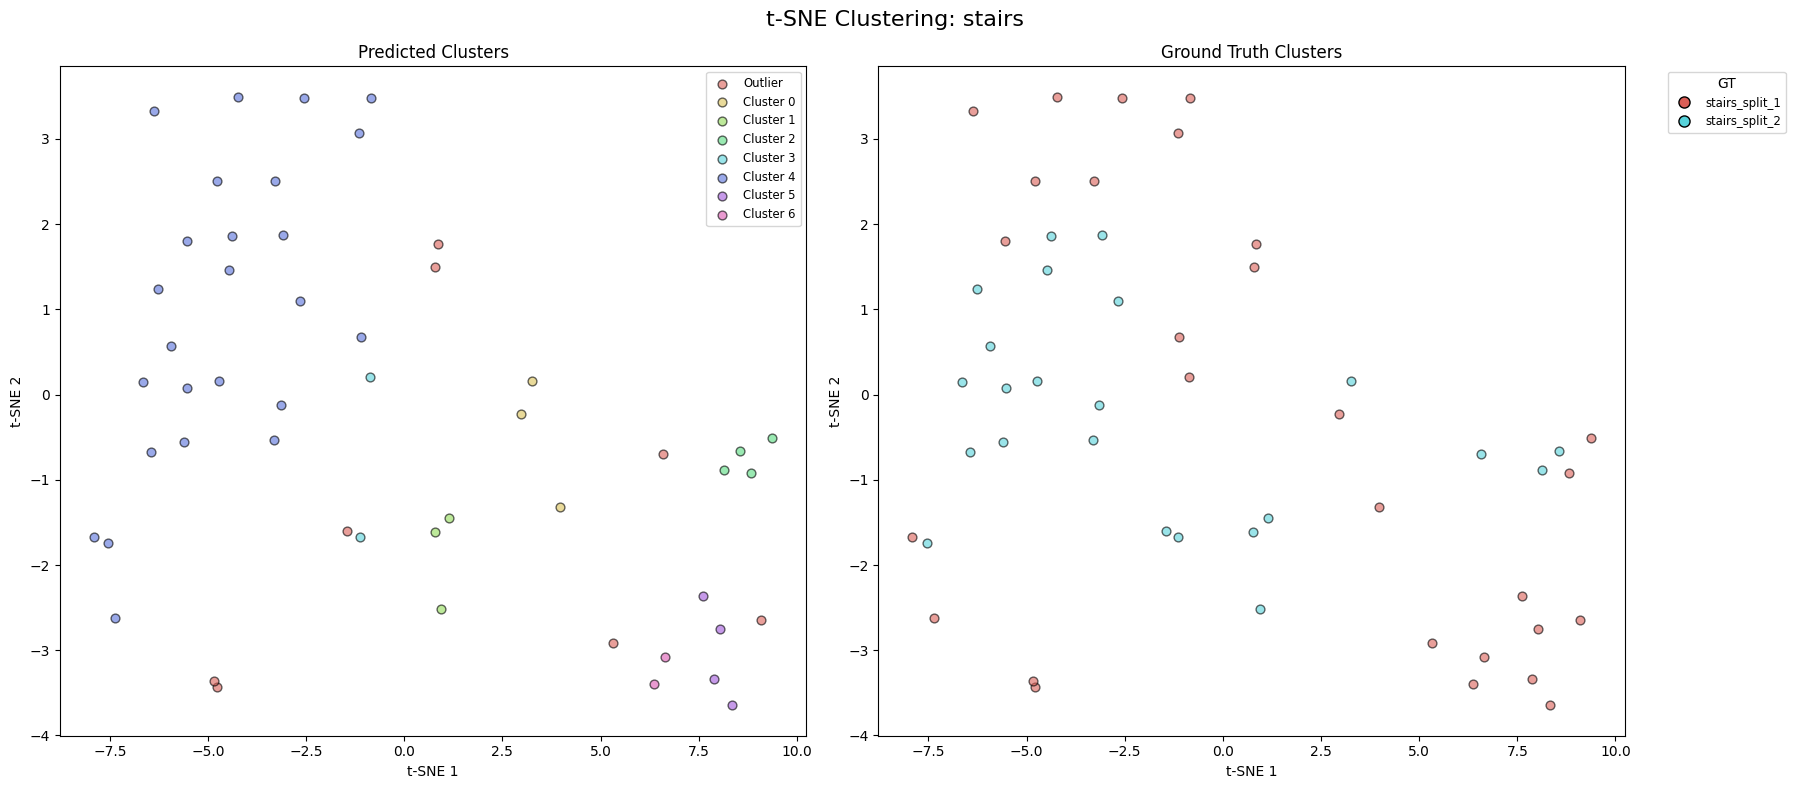

In [8]:
for dataset_name, image_features in all_vectors.items():
    # Step 1: t-SNE on features
    features_2d = features.extraction.feature_reducer(
            algorithm="TSNE",
            features=np.vstack(image_features),
            n_components=2,
            random_state=42,
            perplexity=15
        )

    # Step 2: Run HDBSCAN or any clustering on 2D features
    cluster_labels = features.clustering.dino_clusterer(
            algorithm="HDBSCAN",
            features=features_2d,
            scaler=None,
            min_cluster_size=2,
        )
    silhouette_avg = silhouette_score(features_2d, cluster_labels)
    print(f"Dataset: {dataset_name}, Silhouette Score: {silhouette_avg:.4f}")

    # Step 3: Prepare GT label color map
    gt_labels = all_label_names[dataset_name]  # Make sure this is aligned with image_features
    cluster_names = sorted(set(gt_labels))
    gt_palette = sns.color_palette("hls", len(cluster_names))
    gt_color_map = {name: gt_palette[i] for i, name in enumerate(cluster_names)}
    gt_colors = [gt_color_map[label] for label in gt_labels]

    # Step 4: Prepare prediction label color map
    unique_labels = sorted(set(cluster_labels))
    pred_palette = sns.color_palette("hls", len(unique_labels))
    pred_color_map = {label: pred_palette[i] for i, label in enumerate(unique_labels)}
    pred_colors = [pred_color_map[label] for label in cluster_labels]

    # ---- Plotting both subplots ----
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(f"t-SNE Clustering: {dataset_name}", fontsize=16)

    # --- Left: Prediction ---
    ax = axs[0]
    for label in unique_labels:
        indices = [i for i, l in enumerate(cluster_labels) if l == label]
        subset = features_2d[indices]
        ax.scatter(subset[:, 0], subset[:, 1],
                   c=[pred_color_map[label]],
                   label=f'Cluster {label}' if label != -1 else 'Outlier',
                   s=40, alpha=0.6, edgecolors='k')
    ax.set_title("Predicted Clusters")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(fontsize='small')

    # --- Right: Ground Truth ---
    ax = axs[1]
    for name in cluster_names:
        indices = [i for i, lbl in enumerate(gt_labels) if lbl == name]
        subset = features_2d[indices]
        ax.scatter(subset[:, 0], subset[:, 1],
                   c=[gt_color_map[name]],
                   label=name,
                   s=40, alpha=0.6, edgecolors='k')
    ax.set_title("Ground Truth Clusters")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

    # GT Legend
    handles = [
        Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=gt_color_map[label], markersize=8, markeredgecolor='k')
        for label in cluster_names
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title='GT')

    plt.tight_layout()
    plt.show()